<a href="https://colab.research.google.com/github/naekang/UOS-AI/blob/main/AI_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import pandas as pd
torch.set_printoptions(edgeitems=2, precision=2, linewidth=75)

In [6]:
import csv
wine_path = './winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [7]:
df = pd.read_csv("./winequality-white.csv")
print(df)

     fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
0      7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6                                                                                                                     
1     6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...                                                                                                                     
2     8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...                                                                                                                     
3     7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...                                                                                                                     
4     7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...                                                                                

In [8]:
col_list = next(csv.reader(open(wine_path), delimiter=";"))

wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [9]:
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

wine 데이터에서 quality를 제외하고 데이터 생성

In [10]:
data = wineq[:, :-1] 

data, data.shape

(tensor([[ 7.00,  0.27,  ...,  0.45,  8.80],
         [ 6.30,  0.30,  ...,  0.49,  9.50],
         ...,
         [ 5.50,  0.29,  ...,  0.38, 12.80],
         [ 6.00,  0.21,  ...,  0.32, 11.80]]), torch.Size([4898, 11]))

In [11]:
target = wineq[:, -1] 

target, target.shape


(tensor([6., 6.,  ..., 7., 6.]), torch.Size([4898]))

In [12]:
target = wineq[:, -1].long()

target

tensor([6, 6,  ..., 7, 6])

In [21]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)
target = target_onehot
target

tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])

일반적으로 데이터셋을 분리할 때 훈련 데이터와 검증 데이터를 7:3 또는 8:2의 비율로 나눔

In [22]:
n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

In [23]:
shuffled_indices = torch.randperm(n_samples)
shuffled_indices

tensor([1858, 1272,  ..., 4276, 2125])

In [24]:
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

target_t = target[train_indices]
data_t = data[train_indices]
target_v = target[val_indices]
data_v = data[val_indices]

Adam을 이용한 학습과정

In [38]:
loss_val_data = [] # validation data의 loss 값을 저장하는 리스트
loss_train_data = [] # train data의 loss 값을 저장하는 리스트

# 트레이닝 루프
import torch.nn as nn
def training_loop(n_epochs, optimizer, model, loss_fn, data_t, data_v,
                  target_t, target_v):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(data_t) # <1>
        loss_train = loss_fn(t_p_train, target_t)
        t_p_val = model(data_v) 
        loss_val = loss_fn(t_p_val, target_v)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        loss_val_data.append(loss_val.item())
        loss_train_data.append(loss_train.item())
        if epoch == 1 or epoch % 1000 == 0:
          print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

linear_model = nn.Linear(11, 10)
learning_rate = 1e-3
optimizer = optim.Adam(linear_model.parameters(), lr=learning_rate)

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), 
    data_t = data_t,
    data_v = data_v, 
    target_t = target_t,
    target_v = target_v)

Epoch 1, Training loss 845.1994, Validation loss 852.0998
Epoch 1000, Training loss 5.1177, Validation loss 5.4862
Epoch 2000, Training loss 1.4684, Validation loss 1.5436
Epoch 3000, Training loss 0.3167, Validation loss 0.3338
Epoch 4000, Training loss 0.0940, Validation loss 0.0990
Epoch 5000, Training loss 0.0699, Validation loss 0.0725
Epoch 6000, Training loss 0.0666, Validation loss 0.0686
Epoch 7000, Training loss 0.0644, Validation loss 0.0661
Epoch 8000, Training loss 0.0629, Validation loss 0.0643
Epoch 9000, Training loss 0.0619, Validation loss 0.0631
Epoch 10000, Training loss 0.0613, Validation loss 0.0624


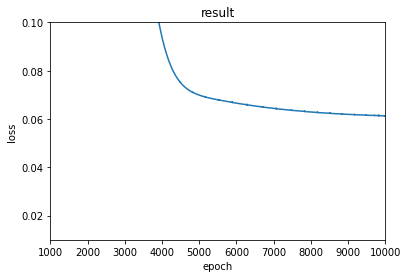

In [41]:
n_epochs = 10000
plt.title('result');
x = range(n_epochs)
y = loss_train_data
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(1000,10000) # X축 범위
plt.ylim(0.01,0.1) # y축 범위
plt.plot(x,y)
plt.show()